In [ ]:

import torch
import torch.nn as nn
from torch.optim import SGD, AdamW
from torchvision.utils import make_grid
import torchvision.transforms as T
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
import numpy as np
from dataclasses import dataclass

from transformers.train import Trainer 
from transformers.utils import get_device, num_params
from transformers.vision.data import CIFARDataLoader
from transformers.vision.base_model import BadNet, VisionModel
from transformers.vision.vgg import VGG16 
from transformers.vision.resnet import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from transformers.vision.vit import VisionTransformer

# reload imported modules automatically (so you dont have to restart kernel when changing .py files)
%load_ext autoreload
%autoreload 2

device = get_device()
print(f"using device: {device}")

using device: mps


{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
45000 5000 10000
352 40
torch.Size([128, 3, 32, 32]) torch.Size([128])


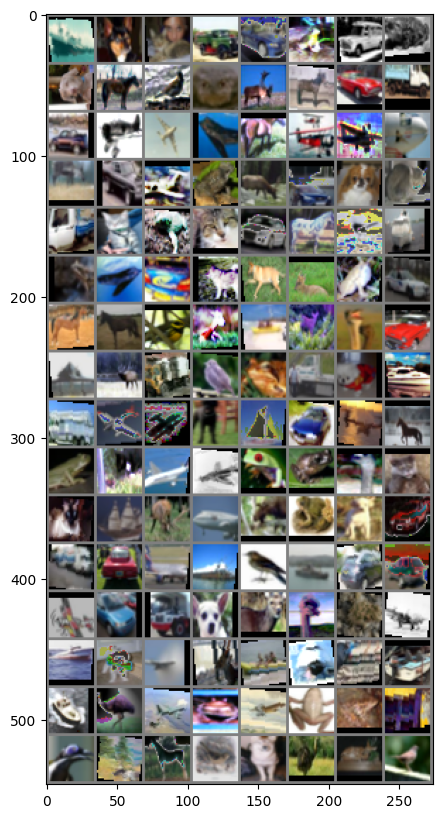

{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}
{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


In [ ]:
train_transform = T.Compose([
    T.RandomResizedCrop(32, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.AutoAugment(policy=T.AutoAugmentPolicy.CIFAR10),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3) # mean 0.5, std 0.5 for each channel
]) 

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
]) 

trainset_full = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
trainset, valset = random_split(trainset_full, [0.9, 0.1])

trainloader = CIFARDataLoader(trainset, batch_size=128, shuffle=True)
valloader = CIFARDataLoader(valset, batch_size=128, shuffle=False)
testloader = CIFARDataLoader(testset, batch_size=128, shuffle=False)

class_to_idx = trainset_full.class_to_idx # type: ignore
idx_to_class = {v: k for k, v in class_to_idx.items()}

def imshow(img: torch.Tensor):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_label_counts_from_dataset(dataset_obj: Dataset):
    label_counts = {}
    
    if isinstance(dataset_obj, torch.utils.data.Subset):
        targets = np.array(dataset_obj.dataset.targets) # type: ignore
    elif hasattr(dataset_obj, 'targets'):
        targets = np.array(dataset_obj.targets) # type: ignore
    else:
        targets = [label for _, label in dataset_obj]

    unique, counts = np.unique(targets, return_counts=True)
    for label, count in zip(unique, counts):
        label_counts[idx_to_class[int(label)]] = int(count)
    return label_counts

print(idx_to_class)
print(len(trainset), len(valset), len(testset))
print(len(trainloader), len(valloader))

batch = next(iter(trainloader))
x, y = batch.x, batch.y
print(x.shape, y.shape)
imshow(make_grid(x))

train_counts = get_label_counts_from_dataset(trainset)
test_counts = get_label_counts_from_dataset(testset)
print(train_counts)
print(test_counts)

In [19]:
model = VisionTransformer(n_classes=10, patch_size=4, n_layers=7, d_emb=384, d_mlp=384, n_head=12, d_head=32, p_dropout=0.0)
model = model.to(device)
print(num_params(model))
# acc, f1 = model.full_eval(test_loader=testloader)

print(model)

batch = next(iter(trainloader))
batch = batch.to(device)
model(batch.x).shape

# model.full_eval(testloader, device=device, idx_to_class=idx_to_class) # type: ignore

6260746
VisionTransformer(
  (embed): EmbeddingLayer(
    (patch_emb): Linear(in_features=48, out_features=384, bias=True)
    (pos_emb): Embedding(65, 384)
  )
  (dropout_embed): Dropout(p=0.0, inplace=False)
  (encoder): TransformerEncoder(
    (blocks): ModuleList(
      (0-6): 7 x TransformerBlock(
        (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): EfficientMultiHeadAttention(
          (wqkv): Linear(in_features=384, out_features=1152, bias=False)
          (wo): Linear(in_features=384, out_features=384, bias=True)
          (dropout_attn): Dropout(p=0.0, inplace=False)
          (dropout_resid): Dropout(p=0.0, inplace=False)
        )
        (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (w1): Linear(in_features=384, out_features=384, bias=True)
          (gelu): GELU(approximate='none')
          (w2): Linear(in_features=384, out_features=384, bias=True)
          (dropout): Dropout(p=0.0, inplace=Fal

torch.Size([128, 10])

In [20]:
def metrics(model: VisionModel):
    acc, f1 = model.full_eval(valloader, device, idx_to_class, verbose=False)
    return {"accuracy": float(acc), "f1": float(f1)}

trainer = Trainer(
    model=model, 
    train_loader=trainloader, # type: ignore 
    val_loader=valloader, # type: ignore
    device=device,
    max_lr=3e-4,
    min_lr=1e-5,
    warmup_steps=1000, 
    weight_decay=5e-3, 
    n_epochs=10, 
    log_steps=50,
    eval_steps=1000, 
    save_steps=1000,
    use_mixed_precision=False,
    compute_metrics=metrics, # type: ignore ,
    max_epochs_without_improvement=5,
    checkpoint_dir="checkpoints/cifar10-vit" 
) 
 
# trainer.optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# trainer.load_checkpoint("checkpoints/cifar10-vit")
# model = trainer.model

val_loss = trainer.eval()
print(val_loss)
trainer.train()

Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


2.3985469818115233
step:     50 (0.14 epochs) | train loss: 2.2523 | lr: 1.00e-03 | steps/s:  4.9 (1.20 mins/epoch)
step:    100 (0.28 epochs) | train loss: 2.0828 | lr: 9.99e-04 | steps/s:  4.9 (1.21 mins/epoch)
step:    150 (0.43 epochs) | train loss: 2.0241 | lr: 9.98e-04 | steps/s:  4.7 (1.25 mins/epoch)
step:    200 (0.57 epochs) | train loss: 1.9799 | lr: 9.95e-04 | steps/s:  4.6 (1.28 mins/epoch)
step:    250 (0.71 epochs) | train loss: 1.9627 | lr: 9.92e-04 | steps/s:  4.5 (1.29 mins/epoch)
step:    300 (0.85 epochs) | train loss: 1.9125 | lr: 9.87e-04 | steps/s:  4.5 (1.31 mins/epoch)
step:    350 (0.99 epochs) | train loss: 1.8894 | lr: 9.82e-04 | steps/s:  4.4 (1.32 mins/epoch)
step:    400 (1.14 epochs) | train loss: 1.8779 | lr: 9.75e-04 | steps/s:  4.4 (1.33 mins/epoch)
step:    450 (1.28 epochs) | train loss: 1.9041 | lr: 9.68e-04 | steps/s:  4.4 (1.35 mins/epoch)
step:    500 (1.42 epochs) | train loss: 1.8594 | lr: 9.59e-04 | steps/s:  4.2 (1.39 mins/epoch)
step:    55

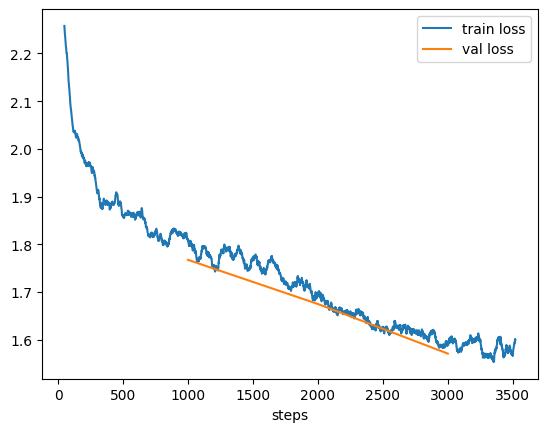

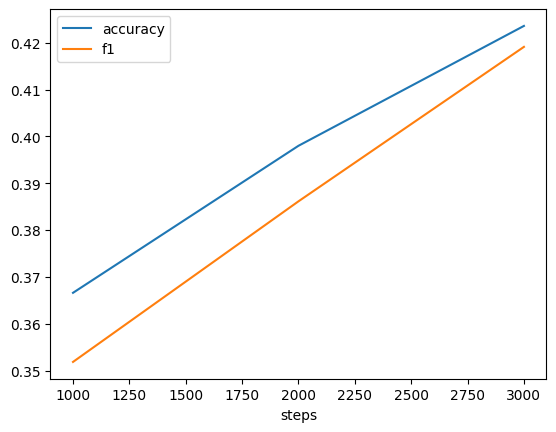

100%|██████████| 79/79 [00:08<00:00,  9.12it/s]


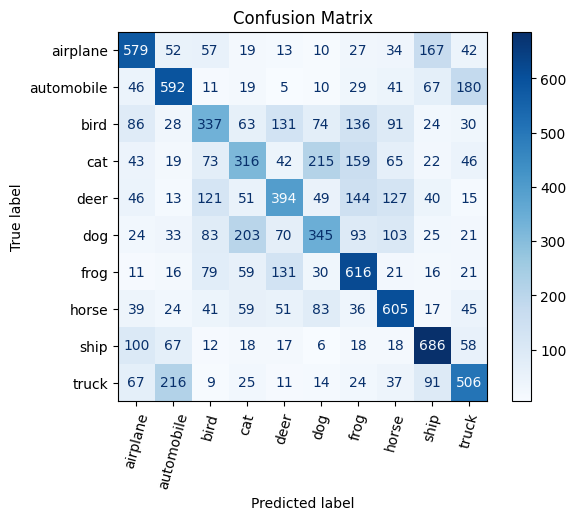

Accuracy: 49.76%
F1 Score (macro): 49.12


(np.float64(0.4976), 0.49118655324787747)

In [21]:
trainer.plot(train_loss_smoothing=None, plot_metrics=True)
model.full_eval(testloader, device=device, idx_to_class=idx_to_class) # type: ignore

In [ ]:
{**trainloader.__dict__, "batch_size": 1}